In [1]:
!pip install ucimlrepo

In [29]:
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from ucimlrepo import fetch_ucirepo

In [3]:
online_retail = fetch_ucirepo(id=352)

In [4]:
online_retail.metadata

{'uci_id': 352,
 'name': 'Online Retail',
 'repository_url': 'https://archive.ics.uci.edu/dataset/352/online+retail',
 'data_url': 'https://archive.ics.uci.edu/static/public/352/data.csv',
 'abstract': 'This is a transactional data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.',
 'area': 'Business',
 'tasks': ['Classification', 'Clustering'],
 'characteristics': ['Multivariate', 'Sequential', 'Time-Series'],
 'num_instances': 541909,
 'num_features': 6,
 'feature_types': ['Integer', 'Real'],
 'demographics': [],
 'target_col': None,
 'index_col': ['InvoiceNo', 'StockCode'],
 'has_missing_values': 'no',
 'missing_values_symbol': None,
 'year_of_dataset_creation': 2015,
 'last_updated': 'Mon Oct 21 2024',
 'dataset_doi': '10.24432/C5BW33',
 'creators': ['Daqing Chen'],
 'intro_paper': {'ID': 361,
  'type': 'NATIVE',
  'title': 'Data mining for the online retail industry: A case study of RFM model

In [5]:
online_retail.variables

,name,role,type,demographic,description,units,missing_values
0,InvoiceNo,ID,Categorical,None,a 6-digit integral number uniquely assigned to...,None,no
1,StockCode,ID,Categorical,None,a 5-digit integral number uniquely assigned to...,None,no
2,Description,Feature,Categorical,None,product name,None,no
3,Quantity,Feature,Integer,None,the quantities of each product (item) per tran...,None,no
4,InvoiceDate,Feature,Date,None,the day and time when each transaction was gen...,None,no
5,UnitPrice,Feature,Continuous,None,product price per unit,sterling,no
6,CustomerID,Feature,Categorical,None,a 5-digit integral number uniquely assigned to...,None,no
7,Country,Feature,Categorical,None,the name of the country where each customer re...,None,no


In [7]:
online_retail_df = pd.DataFrame(online_retail.data.features)
online_retail_df.head()

,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [20]:
online_retail_df['InvoiceDate'] = pd.to_datetime(online_retail_df['InvoiceDate'])

reference_date = online_retail_df['InvoiceDate'].max()

rfm = online_retail_df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,  # Récence
    'CustomerID': 'count',                                      # Fréquence
    'UnitPrice': lambda x: (x * online_retail_df['Quantity']).sum()        # Montant
})



In [22]:
rfm.rename(columns={'InvoiceDate': 'Recency',
                    'CustomerID': 'Frequency',
                    'UnitPrice': 'Monetary'}, inplace=True)

In [23]:
rfm

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,325,2,0.00
12347.0,1,182,4310.00
12348.0,74,31,1797.24
12349.0,18,73,1757.55
12350.0,309,17,334.40
...,...,...,...
18280.0,277,10,180.60
18281.0,180,7,80.82
18282.0,7,13,176.60


In [26]:
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)

In [27]:
rfm_scaled

array([[ 2.32202285, -0.3917197 , -0.23100099],
       [-0.89373323,  0.38265697,  0.29343167],
       [-0.1691956 , -0.26695902, -0.01231622],
       ...,
       [-0.83418219, -0.34439668, -0.20951263],
       [-0.87388289,  2.85205812,  0.02390005],
       [-0.48680114, -0.0991774 , -0.00744423]])

In [32]:
kmeans = KMeans(n_clusters=3, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

In [33]:
segment_summary = rfm.groupby('Cluster').mean()
print(segment_summary)

           Recency    Frequency       Monetary
Cluster                                       
0         39.19344   104.924280    1951.687769
1        246.04827    27.704007     463.664873
2          4.00000  2845.583333  118713.023333


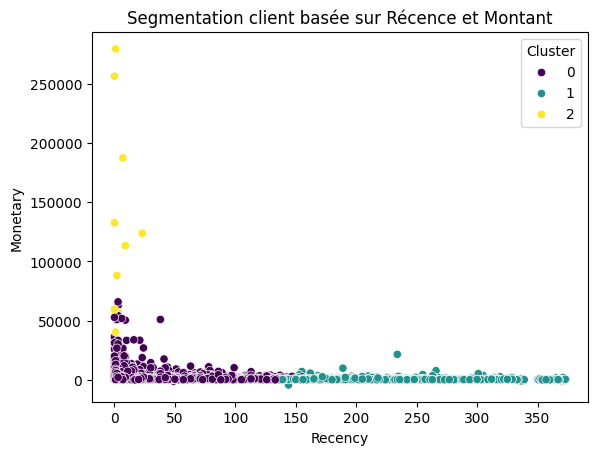

In [34]:
sns.scatterplot(x=rfm['Recency'], y=rfm['Monetary'], hue=rfm['Cluster'], palette="viridis")
plt.title('Segmentation client basée sur Récence et Montant')
plt.show()